# Jet-Coastal Current

## Governing Equations
In the farfield, where the jet has deflected and settled into geostrophic balance oriented parallel to isobaths, the steady continuity and momentum equations are

$$ \frac{\partial }{\partial s}(VH) + \frac{\partial \alpha}{\partial n} = 0 $$ 

$$ 
V\frac{\partial V}{\partial s} +  
C_D \frac{V^2}{H}  +
g \frac{\partial \eta}{\partial s}  = 0 
$$

$$ 
V^2 K +
fV +
g \frac{\partial \eta}{\partial n}  = 0
$$

with a radial bathymetric profile 

$$ h(r) = h_0 + \lambda r $$

**note**: the nonlinear term in the normal component is retained to account for the curvature of isobaths to be expected around and island

## Jet Nearfield: rapid adjustment to topography

Where the barotropic outflow is normal to topography ($\hat{r} \sim \hat{s}$ are coincident), we can derive an expression for velocity from continuity (1) given a bathymetric profile. Ignoring diffluence and applying (4)

$$ V(s)' = -\frac{V\lambda}{H_0 + \lambda s}$$ 

admits the simple solution 

$$V(s) = \frac{V_0H_0}{H_0 + \lambda s}$$

which after substitution into the streamwise momentum equation, (2) can be rearranged into a separable first order ODE for the free surface

<!-- $$ \eta(s)^{'} = \frac{V_0^2H_0^2(\lambda - C_D)}{g(H_0 + \lambda s)^3} $$

$$ \frac{-V^2\lambda}{H_0 + \lambda s} + C_D\frac{V^2}{H_0 + \lambda s} + g\frac{\partial \eta}{\partial s} = 0 $$

which is a separable first order ODE for the free surface

$$ \eta(s)^{'} = \frac{V^2(s)(\lambda - C_D)}{g(H_0 + \lambda s)} $$

which, after invoking the solution for $V(s)$

$$ \eta(s)^{'} = \frac{V_0^2H_0^2(\lambda - C_D)}{g(H_0 + \lambda s)^3} $$

admits the analytic solution -->
 
$$\eta(s) = 
\frac{V_0^2H_0^2(C_D - \lambda )}{2 g \lambda(H_0 + \lambda s)^2} - 
\frac{V_0^2(C_D - \lambda )}{2 g \lambda} +
\eta_0
$$
<!-- which can be solved numerically after substituting in the continuity solution $V(s) = \frac{V_0}{H_0 + \lambda(s - R_i)}$ -->

The normal momentum equation (3), assuming a cosine jet profile, can be integrated to solve for $\eta_0$. Also using the shear equation (the normal derivative of (3)), rearranged to solve for the cross-stream variation of curvature, the system of equations to be solved are 

#### Velocity profile
$V(n) = \frac{V_0}{2}(1+\cos{\frac{2\pi n}{W_J}})$
#### Shear profile
$ V' = - \frac{2\pi}{W_J}\sin{\frac{2\pi n}{W_J}} $
#### Shear equation (normal derivative of CoMM)
$ \Xi'= \frac{V'(f - 2K) - K'}{g}$  
#### Conservation of PV (normal derivative)
$ K' = \frac{V'' - V'K}{V}  $

We also define a new function $\Xi = \eta'$ to reduce the system to first order ($V$ and its derivatives are known a priori in terms of constants and the independent variable $n$). After applying the boundary condition $\Xi(n = 0) = 0$ (local free surface maximum at centerline) and $K(n=0) = -V_0/f$ the ODE system can be integrated numerically.

In [634]:
r = sym.symbols("r", real = True)
n = sym.symbols("n", real = True)
K = sym.symbols("K", real = True)

𝜂 = sym.Function("eta", real = True)(n)
x = sym.Function("Xi", real = True)(n)
v = sym.Function("v", real = True)(n)
k = sym.Function("k", real = True)(n)
g, v0, f, W = sym.symbols('g v0 f W_J', real = True, constant = True)

In [633]:
sym.solve( sym.Eq(d𝜂dr.diff(n), 0), k.diff(n))[0]

-(f + 2*k(n)*v(n))*Derivative(v(n), n)/v(n)**2

In [640]:
sym.solve(sym.Eq(com.lhs.diff(n) - com.rhs.diff(n),0), v.diff(n))[0]

-(g*Derivative(eta(n), (n, 2)) + v(n)**2*Derivative(k(n), n))/(f + 2*k(n)*v(n))

In [641]:
v = v0*(1 + sym.cos(2*sym.pi*n/W))/2
com = sym.Eq(𝜂.diff(n), -v*(v*k + f)/g)
d𝜂dn = -v*(v*k + f)/g
shear = sym.Eq( k.diff(n), v.diff(n)*(f - 2*k) + g*d𝜂dn.diff(n))
               #sym.solve( sym.Eq(k.diff(r), v.diff(r)*(f - 2*k) + g*d𝜂dr.diff(r)), k.diff(r))[0].subs(v.diff(r),f+v*k))
shearsol = sym.solve(shear, k.diff(n))[0]
F_dk = sym.lambdify( (n,K,v0,W), shearsol.subs(k,K),'numpy')
F_dn = sym.lambdify( (n,K,f,v0,W,g), d𝜂dn.subs(k,K), 'numpy')

eqs = [sym.Eq(sym.S("v(n)"),v),com,sym.Eq(k.diff(n),shearsol)]
for e in eqs:
    display(e.simplify())

Eq(v(n), v0*(cos(2*pi*n/W_J) + 1)/2)

Eq(Derivative(eta(n), n), -v0*(f + v0*k(n)*cos(pi*n/W_J)**2)*(cos(2*pi*n/W_J) + 1)/(2*g))

Eq(Derivative(k(n), n), pi*v0*(v0*cos(2*pi*n/W_J) + v0 + 2)*k(n)*sin(2*pi*n/W_J)/(W_J*(v0**2*cos(pi*n/W_J)**4 + 1)))

In [ ]:
import hvplot.pandas
import holoviews as hv
from scipy.integrate import solve_ivp, cumulative_trapezoid
from pycoawst.utility.general import coriolis
hv.extension("bokeh")

def detadn(n, k, f = 1e-4, v0 = 0.25, W = 1000, g = 9.81):
    return -(v0/(2*g))*(f + v0*k*np.cos(np.pi*n/W)**2)*(np.cos(2*np.pi*n/W) + 1)

def curvature(n, z, v0 = 0.25, f = -3.5e-5, W = 1000):
    Ξ, k = z
    return F_dk(n = n, K = k, W_J = W, v0 = v0)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
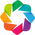

:Layout
   .Curve.I   :Curve   [n]   (𝜂)
   .Curve.II  :Curve   [n]   (V)
   .Curve.III :Curve   [n]   (R)
   .Overlay.I :Overlay
      .NdOverlay.I :NdOverlay   [Variable]
         :Curve   [n]   (value)
      .HLine.I     :HLine   [x,y]

In [623]:
v0 = .25
f0 = coriolis(-30)
k0 = [-f0/v0]
W = 1e3

#Curvature B.C. applied at center - leverage symmetry of problem
K = []
rs = []
for ni,nf in zip( [0, 0], [-W/2, W/2] ):
    ns = np.linspace(ni,nf,1000)
    sol = solve_ivp(curvature, [ni,nf], k0, args = (v0,f0,W), dense_output = True)
    K += [sol.sol(ns).flatten()]
    rs += [-ns] 

K = np.concatenate( (K[1][::-1], K[0][1:]) )
rs = np.concatenate( (rs[1][::-1], rs[0][1:]) )
ns = -rs

V = v0*(1 + np.cos(2*np.pi*ns/W))/2
d𝜂dn = F_n(ns, K = K, f = f0, v0 = v0, W_J = W, g = 9.81)
𝜂 = cumulative_trapezoid(d𝜂dn, ns, initial = 0)

pgf = 9.81*d𝜂dn
nlr = V**2*K
cor = V*f0
net = pgf + nlr + cor

names = ["n","K","V","𝜂","pgf","nlr","cor","net"]
data = [ns, K, V, 𝜂, pgf, nlr, cor, net]
D = dict(zip(names,data))
df = pd.DataFrame.from_dict(D)
df["R"] = 1/df["K"]

opts = {"invert_xaxis": True}
zero = hv.HLine(0).opts(line_width = 1, color = "k", alpha = .25)
(df.hvplot.line(x = "n", y = "𝜂", color = "black").opts(**opts) +
 df.hvplot.line(x = "n", y = "V", color = "black").opts(**opts) +
 df.hvplot.line(x = "n", y = "R", color = "black").opts(**opts) +
 df.hvplot.line(x = "n", y = ["pgf", "nlr", "cor"]).opts(**opts)*zero
).cols(2).opts(shared_axes = False)

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import holoviews as hv
import hvplot.pandas

from scipy.optimize import fsolve

class momentumAnalysis():
    
    g = 9.81
    
    def __init__(self, V0 = 0.25, H0 = 20, 𝜆 = 0.1, Cd = 0.0625, W = 1e3, latitude = -30):
        self.V0 = V0
        self.H0 = H0
        self.𝜆 = 𝜆 
        self.Cd = Cd
        self.W = W
        self.f = 2*7.29e-5*np.sin(latitude*np.pi/180)
        
    def eta_init(self):
        """Compute initial free surface slope based on cyclogeostrophic balance.
            Assume initial curvature is set by the nearfield inertial radius V0/f then integrate the normal momentum equation"""
        self.𝜂0 = -self.W*self.f*self.V0/self.g
    
    def depth(self,s): #,H0,𝜆):
        """Compute depth profile """
        return self.H0 + self.𝜆*s
        
    def speed(self,s): #, V0 = 0.25, H0 = 20, 𝜆 = 0.1):
        return self.V0*self.H0/(self.H0 + self.𝜆*s)
    
    def speed_grad(self,s):
        return -self.V*self.𝜆/(self.H0+s*self.𝜆)
    
    def eta(self, s, 𝜂0 = 0.1, V0 = .25, Cd = 1e-3, 𝜆 = 0.1, H0 = 20, g = 9.81):
        return -V0**2*H0**2*(Cd - 𝜆)/(2*g*𝜆*(𝜆*s + H0)**2) - V0**2*(Cd - 𝜆)/(2*g*𝜆) + 𝜂0
        
    def free_surface(self,s): #, 𝜂0 = 0.1, V0 = .25, Cd = 1e-3, 𝜆 = 0.1, H0 = 20, g = 9.81):
        #return -V0**2*(Cd - 1/𝜆)/(2*g*𝜆*(𝜆*s + H0)**2) + V0**2*(Cd - 1/𝜆)/(2*g*𝜆*H0**2) + 𝜂0
        return   self.V0**2*self.H0**2*(self.Cd - self.𝜆)/(2*self.g*self.𝜆*(self.H0 + self.𝜆*s)**2) + \
                -self.V0**2*(self.Cd - self.𝜆)/(2*self.g*self.𝜆) + self.𝜂0
    
    def eta_slope(self, s):#, V0 = .25, Cd = 1e-3, 𝜆 = 0.1, H0 = 20, g = 9.81):
        return self.V0**2*self.H0**2*(self.𝜆 - self.Cd)/(self.g*(self.H0 + self.𝜆*s)**3)

    def dia_sw(self, dvds,V,Cd,H,dnds): # g = 9.81):
        nl = V*dvds
        drag = Cd*V**2/H
        pgf = self.g*dnds
        return nl, drag, pgf

    def state(self,s):
        self.s = s
        self.H = self.depth(s)
        self.V = self.speed(s)
        self.eta_init()
        self.𝜂 = self.free_surface(s)
        self.dvds = self.speed_grad(s)
        self.d𝜂ds = self.eta_slope(s)
        
        self.sw_nlr, self.sw_drg, self.sw_pgf = self.dia_sw(self.dvds, self.V, self.Cd, self.H, self.d𝜂ds)
    
    def excursion(self,r): #,v0,h0,𝜆,g):
        """use conservation of normal momentum to solve for r."""
        Vf = self.V0*self.H0/(self.H0+self.𝜆*r)
        detadn_i = self.𝜂0/self.W
        #detadn_f = self.eta(r, 𝜂0 = self.𝜂0, V0 = self.V0, Cd = self.Cd, 𝜆 = self.𝜆, H0 = self.H0, g = self.g)/r
        
        return -Vf**2/( self.f*(2*self.V0 - Vf) + self.g*(detadn_i - detadn_f) ) - r
    
    def excursion_solve(self):
        return fsolve(self.excursion, 5e3)
    
    def make_df(self):
        names = ["s", "depth", "speed", "𝜂", "dnds", "dvds", "nonlinear", "drag", "pgf"]
        data = [self.s, self.H, self.V, self.𝜂, self.d𝜂ds, self.dvds, self.sw_nlr, self.sw_drg, self.sw_pgf]
        df = pd.DataFrame.from_dict(dict(zip(names,data)))
        return df

In [8]:
s = np.linspace(0, 2e3, 1000)  
r = np.linspace(1,4e3, 1000)

V0 = 0.25
H0 = 20
𝜂0 = 0.01
𝜆 = 0.1
Cd = 0.03
M = momentumAnalysis(V0 = V0, H0 = H0, 𝜆 = 𝜆, Cd = Cd)
M.state(s)
#R = M.excursion_solve()
df = M.make_df()

#value = M.excursion(r)
#sns.lineplot(r, value)

In [9]:
zero = hv.HLine(0).opts(line_width = 1, color = "k", alpha = .25)
(df.hvplot.line(x = "s", y = ["nonlinear", "drag", "pgf"]) * zero +
 df.hvplot.line(x = "s", y = "𝜂") * zero).cols(1)

:Layout
   .Overlay.I  :Overlay
      .NdOverlay.I :NdOverlay   [Variable]
         :Curve   [s]   (value)
      .HLine.I     :HLine   [x,y]
   .Overlay.II :Overlay
      .Curve.I :Curve   [s]   (𝜂)
      .HLine.I :HLine   [x,y]

## Jet Farfield: the transition to coastal current



As the jet will eventually deflect and align itself to isobaths due to Coriolis acceleration, we now seek to derive a length scale $\mathbb{R}$ for the radial excursion distance over which this transition occurs. Notice that once the jet has aligned to isobaths, the radial and normal directions are coincindent ($\hat{r} \sim \hat{n}$), which will facilitate the analysis.

#### Conservation of PV 
Assuming the initial motion of the jet is inertial i.e. $K = \frac{f}{V_J}$, its initial net potential vorticity = 0, also assumming shear can be ignored or averaged out. If PV is conserved along the path of the jet, then the subsequent coastal current also has PV = 0, but, its radius of curvature is determined by the radial location of the isobath $R = r + R_i$, where $R_i$ is the island radius. 

$$ f - \frac{dV}{dr} + \frac{V}{R} = 0 $$

This can be separated and integrated to solve for $V$ applying the no-slip boundary condition at the shore $V(r = 0) = 0$. 

$$ V = fR\log{ \frac{R}{R_i} } $$

#### Conservation of mass
Now we can apply conservation of mass to estimate the width of the coastal current $R_c$ for a given outflow mass flux $Q_0 = V_JW_JH_0$.

$$ \int_{0}^{R_c} V(r)h(r) dr = Q_0 $$

With a known depth $h(r) = H_0 + \lambda r$ and velocity profile, the above can be integrated and solved for $R_c$

In [231]:
import sympy as sym

r = sym.symbols('r', real = True)
𝜂 = sym.Function('eta', real = True)
h0, v0, q0, l, f, Ri, Wc, Wj, g = sym.symbols('h0 V0 q0 lambda f R_i W_c W_j g', real = True, constant = True)
#free_surface = sym.solve(sym.Eq(v**2/r + f*v + g*𝜂(r).diff(r), 0), 𝜂(r).diff(r))[0].simplify()
R = r + Ri
v = f*R*sym.log(R/Ri) #define velocity function
h = h0 + l*r #define depth profile
expr = v*h #integrand
result =  sym.integrate(expr,(r,0,Wc))
eqn = sym.Eq(result,v0*h0*Wj)
fn = (result - v0*h0*Wj)
eqn.simplify()

#Taylor expansions of log terms??
# approx = eqn.simplify().subs(sym.log(Ri+Wc), sym.log(Ri) + Wc/Ri - 0*0.5*(Wc/Ri)**2)\
#               .subs(sym.log( (Ri+Wc)/Ri ), Wc/Ri - 0*0.5*(Wc/Ri)**2).simplify()
# #approx = approx.subs(36*Ri, Wc)
# approx
#sym.solve(approx, Wc, check = False)[0].simplify()

Eq(V0*W_j*h0, f*(6*R_i**2*(R_i*lambda - 3*h0)*log(R_i) - 6*R_i**2*(R_i*lambda - 3*h0)*log(R_i + W_c) + 6*R_i*W_c*(R_i*lambda - 3*h0) - 4*W_c**3*lambda - 3*W_c**2*(R_i*lambda + 3*h0) + 6*W_c*(3*R_i*W_c*lambda + 6*R_i*h0 + 2*W_c**2*lambda + 3*W_c*h0)*log((R_i + W_c)/R_i))/36)

which although a bit unwieldy and quite nonlinear, can be solved implicitly using scipy's *fsolve* root finding function. For the parameters used in model simulations
$\lambda = 0.1, H_0 = 20m, R_i = 12e3, f = 3.6e-5, W_J = 1000, V_0 = 0.25 m/s$

In [121]:
from IPython.display import display, Math
F = sym.lambdify( (Wc,l,h0,Ri,f,Wj,v0), fn, 'numpy')
Fv = sym.lambdify((f,r,Ri), v)
wc = fsolve(F, 1e3, args = (0.1, 20, 12e3, 3.645e-5, 1000, 0.25) )
vc = Fv(3.645e-5,wc,12e3)
display(Math(fr"$W_c = {int(wc[0])} m$"))
display(Math(fr"$V_c = {vc[0]:0.3f} m/s$"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [135]:
from pycoawst.utility.general import coriolis
from scipy.integrate import cumulative_trapezoid, trapezoid

f0 = coriolis(-30)
r = np.linspace(1, wc).flatten()
h = (20 + .1*r)
v = Fv(3.645e-5,r,12e3)

nlr = v**2/r
cor = v*f0
pgf = -nlr-cor
eta = cumulative_trapezoid(pgf/9.81,r, initial = 0)
names = ["r","speed", "𝜂", "nonlinear", "coriolis", "pgf"]
data = [r,v, eta, nlr, cor, pgf]

D = dict(zip(names,data))
df = pd.DataFrame.from_dict(D)

zero = hv.HLine(0).opts(line_width = 1, color = "k", alpha = .25)
(
df.hvplot.line(x = "r", y = ["nonlinear", "coriolis", "pgf"]) * zero + 
df.hvplot.line(x = "r", y = "𝜂", color = "k") + 
df.hvplot.line(x = "r", y = ["speed"], color = "k")
).opts(shared_axes = False)


:Layout
   .Overlay.I :Overlay
      .NdOverlay.I :NdOverlay   [Variable]
         :Curve   [r]   (value)
      .HLine.I     :HLine   [x,y]
   .Curve.I   :Curve   [r]   (𝜂)
   .Curve.II  :Curve   [r]   (speed)

A quick plot of the momentum balance terms, free surface, and velocity profile illustrate the nature of the solution.

## Coastal Current

Once the coastal current has been established, we are now interested in its downcoast propagation and therefore turn our attention to the streamwise momentum equation (2). Due to the azimuthally periodic boundary conditions naturally arising from the problem geometry, it is actually not possible to support a net free-surface slope, in that direction i.e. $\int g\frac{\partial \eta(r,\theta)}{\partial \theta}\partial \, \theta = 0$. Thus, once the flow aligns to isobaths directly oriented to the azimuthal coordinate, it is reasonable to argue that $g\frac{\partial \eta}{\partial s} \approx 0$ once the coastal current has been established.

As a consequence, equation (1) reduces to 

$$V \frac{\partial V}{\partial s} = -C_D \frac{V^2}{H} $$,

an ordinary differential equation that can be solved by separation of variables, admitting the solution

$$ V(s) = V_0 e^{-\frac{C_D}{H}s} $$

And so an e-folding decay length scale ($\mathbb{S}$) can be established 
$$\mathbb{S} = 3\frac{H}{C_D}$$

($e^{-3}$ decays to 5% of the inital value, while $e^{-4}$ decays to 1.8%) 
providing rough estimate of the alongshore extent of the feature before it is dissipated by friction. Note that in order to satisfy continuity, the streamwise confluence due to frictional damping of the velocity field would induce radial spreading of the jet.

In our problem, where $H(r) = H_0 + \lambda (r - R_i)$, 

$$\mathbb{S} = 3 \frac{ H_0 + \lambda (R - R_i)}{C_d}$$

where R is the offshore extent of the jet before it aligns to isobaths. 



### sandbox 
which can be non-dimensionalized by introducing $s = Rs^*$ as the offset distance, use the wave height $\eta = H_s\eta^*$ as a naive scaling for the free surface variation, the bathymetric slope for the topographic continuity term scale $\lambda \approx \frac{\partial H}{\partial s}$, and a typical jet spreading angle ($d\sigma = 15^{\circ}= \pi/24$) over the jet width $W_J$

$$ \lambda \frac{V^2}{H} - \frac{\pi}{24}\frac{V^2}{W_J} + C_D\frac{V^2}{H} + \frac{g H_s}{R}\frac{\partial \eta^*}{\partial s^*} = 0$$
where $H(r) \sim \lambda R$ can be substituded in and terms rearranged to solve for $R$

$$ R = \frac{24W_J}{\pi}\big[ \frac{g H_s}{V^2}\frac{\partial \eta^*}{\partial s^*} + 1 + \frac{C_D}{\lambda} )\big]
            $$


Using continuity w/ $H = h + \eta$ in combination with the streamwise momentum equation gives us two equations and two unknowns $(V,\eta)$. Combining we get

$$ V' = \frac{-C_D\frac{V^2}{H} + g\lambda}{V + \frac{gH}{V}} $$

which can be analytically solved?

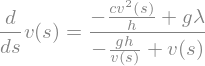

In [4]:
import sympy as sym
sym.init_printing()

s = sym.symbols('s', real = True)
l, g, c, h, v0 = sym.symbols('lambda g c h, v0', real = True, constant = True)

v = sym.Function('v')(s)
dvds = v.diff(s)
expr = sym.Eq(dvds, (-c*v**2/h + g*l)/(v - g*h/v) )
expr

In [319]:
sol = sym.dsolve(expr)

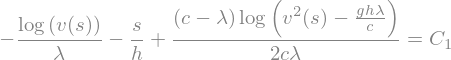

In [320]:
display(sol)#sym.simplify(sol))

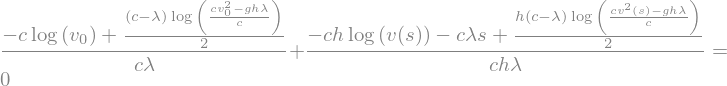

In [321]:
c1 = sol.subs(v, V0).subs(s, 0).lhs
eqn = sym.Eq(sol.lhs, c1)
solution = sym.Eq( eqn.simplify().lhs + eqn.simplify().rhs, 0)
solution

In [307]:
f = sym.lambdify( (s, l, g, c, h, v0), solution.lhs, "math")
help(f)

Help on function _lambdifygenerated:

_lambdifygenerated(s, lambda_, g, c, h, v0)
    Created with lambdify. Signature:
    
    func(s, lambda, g, c, h, v0)
    
    Expression:
    
    (-c*log(v0) + (c + lambda)*log((c*v0**2 - g*h*lambda)/c)/2)/(c*lambda) +...
    
    Source code:
    
    def _lambdifygenerated(s, lambda_, g, c, h, v0):
        return ((-c*log(v0) + (1/2)*(c + lambda_)*log((c*v0**2 - g*h*lambda_)/c))/(c*lambda_) + (-c*h*log(v(s)) + c*lambda_*s + (1/2)*h*(c + lambda_)*log((c*v(s)**2 - g*h*lambda_)/c))/(c*h*lambda_))
    
    
    Imported modules:



In [1]:


args = (1, 9.81, 0.01, 20, 0.25)
fsolve(f, 0.25, args = args)

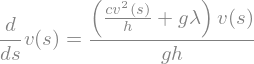

In [287]:
#simplify assume gh/v >> V
expr = sym.Eq(dvds, (c*v**2/h + g*l)/(g*h/v) )
expr

In [289]:
sol2 = sym.dsolve(expr)

In [ ]:
display(sol2)

In [2]:
args = (.1,9.81,0.01,20)
f(s, *args)

In [83]:
# sym.solve(expr,'r')
def cons_pv(r, h0 = 20, v0 = 0.25, 𝜆 = 0.1, f = -3e-5):
    return v0*h0*(-1/( (h0+𝜆*r)*r + 1/( r*(h0+𝜆*r) )) - f

# fsolve(cons_pv, 5e3)

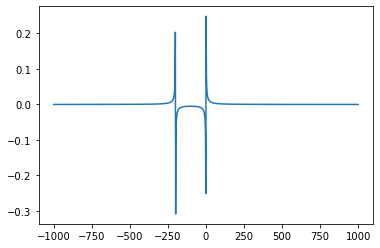

In [86]:
r = np.linspace(-1e3,1e3,1000)

value = cons_pv(r)
sns.lineplot(r,value)

In [382]:
(dvdn + vk + f)/h0 = (dvdn + v/r + f)/(h0 + r*l)
dvdn = -v/r - f


SyntaxError: can't assign to operator (<ipython-input-382-9ff03fbfd973>, line 1)

## free surface solution

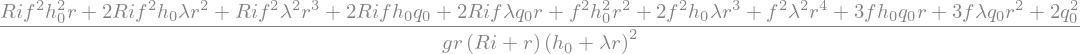

In [428]:
expr = sym.solve(sym.Eq(shear, 0), 𝜂.diff(n).diff(n))
#sol = sym.integrate(sym.integrate(expr[0], r) + c1, r) #.simplify() 

#sym.Eq( (sol + c2).simplify(i
expr[0].simplify()

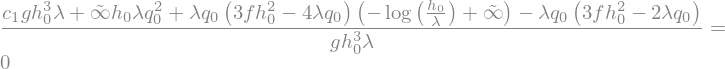

In [394]:
#sol.diff(r).simplify()
sym.Eq(sol.diff(r).subs(r,0),0)

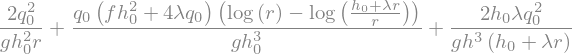

In [373]:
#Apply bc's dn/dr(r = 0) = 0 no slip

#bc1 = 2*f*q0*(-1 + sym.log(r) - sym.log(h0/l) )/(g*h0) + 2*q0**2/(h0**2*r*g)
bc1 = q0*(f*h0**2 + 4*l*q0)*(sym.log(r) - sym.log( (h0+l*r)/r) )/ (g*h0**3) + 2*q0**2/(g*h0**2*r) + 2*h0*l*q0**2/(g*h**3*(h0+l*r))

bc1
#eta_ana = sol.subs(c1,bc1).simplify().diff(r).subs(r,0) #check BC
#eta_ana.diff(r).simplify()
#eta_ana

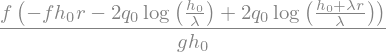

In [291]:
detadr_ana = sol.subs(c1,bc1).diff(r).simplify()
detadr_ana

In [292]:
F_eta = sym.lambdify( (r, f,h0,l,q0,g), eta_ana, 'numpy')
F_detadr = sym.lambdify( (r, f,h0,l,q0,g), detadr_ana, 'numpy')

In [293]:
rn = np.linspace(1,10e3,1000)
fs = F_eta(rn, -3e-5, 20, 0.1, 20*0.25,9.81)
dfs = F_detadr(rn, -3e-5, 20, 0.1, 20*0.25,9.81)

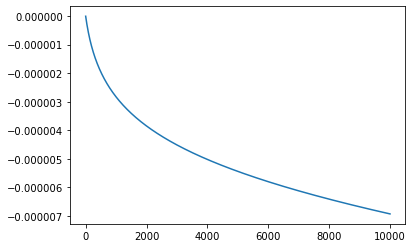

In [310]:
#sns.lineplot(rn,fs)
sns.lineplot(rn,dfs)

In [312]:
def gradient_wind(r, f, dndr, g = 9.81):
    return -r*f/2 + (r**2*f**2/4 - r*g*dndr)**(0.5), \
           -r*f/2 - (r**2*f**2/4 - r*g*dndr)**(0.5)

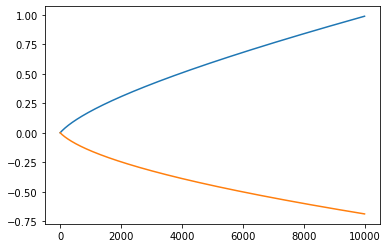

In [315]:
vt1, vt2 = gradient_wind(rn, -3e-5, dfs)

sns.lineplot(rn,vt1)
sns.lineplot(rn,vt2)